In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from xgboost import XGBClassifier
import shap
import joblib
import scipy.sparse as sp


# 프로젝트 루트 경로 추가
ROOT_DIR = os.path.dirname(os.path.abspath("."))
DATA_DIR = os.path.join(ROOT_DIR, "data")

PROCESSED_DATA_PATH = Path(os.path.join(DATA_DIR, "processed/dataset.parquet"))
ART_PATH = Path(os.path.join(ROOT_DIR, "artifacts"))
FIG_PATH = Path(os.path.join(ROOT_DIR, "figures"))
FIG_PATH.mkdir(parents=True, exist_ok=True)

DATA_DIR

'/Users/tykim/Desktop/work/SNU_bigdata_fintech_2025/hotel_booking_cancel_classification/data'

In [16]:
DATA = Path(os.path.join(DATA_DIR, "processed"))
OUT = Path(os.path.join(ROOT_DIR, "figures"))
OUT.mkdir(exist_ok=True, parents=True)

df = pd.read_parquet(DATA / "dataset.parquet")

df = df.sort_values("arrival_date")
y = df["is_canceled"].astype(int).values

In [17]:
def savefig(name):
    plt.tight_layout()
    plt.savefig(OUT / f"{name}.png", dpi=160)
    plt.close()

def showfig(name):
    plt.figure()
    plt.show()
    # savefig(name)


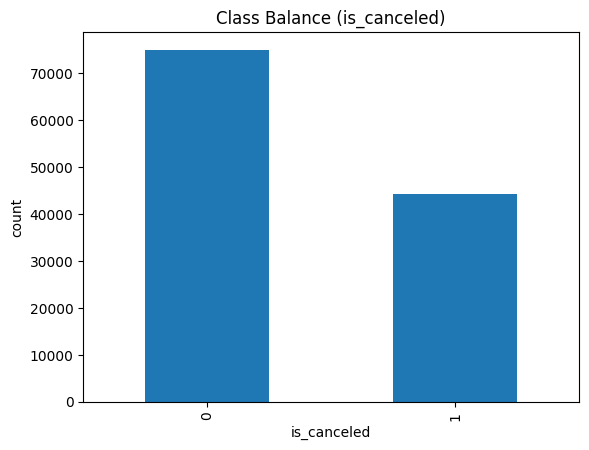

<Figure size 640x480 with 0 Axes>

In [18]:
# 1) 클래스 불균형
plt.figure()
df["is_canceled"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Balance (is_canceled)")
plt.xlabel("is_canceled")
plt.ylabel("count")
showfig("01_class_balance")

/var/folders/0s/sp4g2zrn7mvbj6tfg7z3yqpw0000gn/T/ipykernel_17665/773054611.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


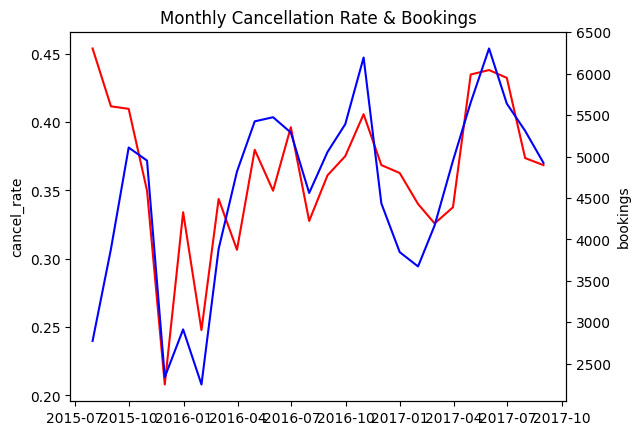

<Figure size 640x480 with 0 Axes>

In [19]:
# 2) 월별 추이
m = (
    df.set_index("arrival_date")
    .resample("M")
    .agg(booked=("is_canceled", "size"), canceled=("is_canceled", "sum"))
)
m["cancel_rate"] = m["canceled"] / m["booked"]
fig, ax1 = plt.subplots()
ax1.plot(m.index, m["cancel_rate"], color="red")
ax1.set_ylabel("cancel_rate")
ax2 = ax1.twinx()
ax2.plot(m.index, m["booked"], color="blue")
ax2.set_ylabel("bookings")
plt.title("Monthly Cancellation Rate & Bookings")
showfig("02_monthly_rate")

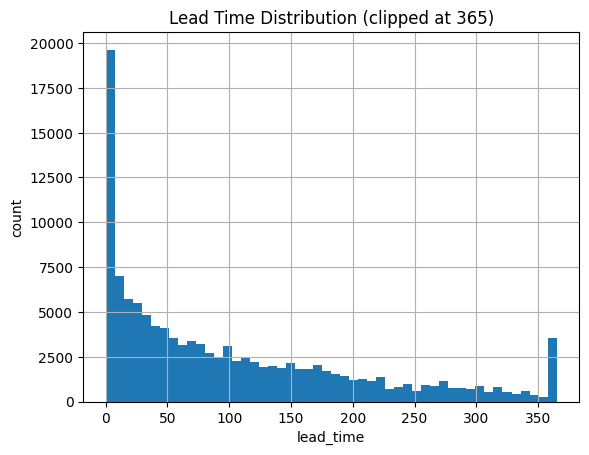

<Figure size 640x480 with 0 Axes>

/var/folders/0s/sp4g2zrn7mvbj6tfg7z3yqpw0000gn/T/ipykernel_17665/3232713598.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(bins)["is_canceled"].mean()


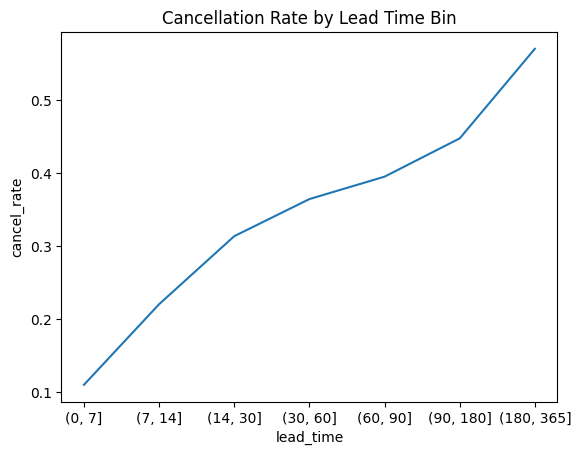

<Figure size 640x480 with 0 Axes>

In [20]:
# 3) lead_time
plt.figure()
df["lead_time"].clip(upper=365).hist(bins=50)
plt.title("Lead Time Distribution (clipped at 365)")
plt.xlabel("lead_time")
plt.ylabel("count")
showfig("03_lead_time_hist")

bins = pd.cut(df["lead_time"].clip(upper=365), bins=[0, 7, 14, 30, 60, 90, 180, 365])
rate = df.groupby(bins)["is_canceled"].mean()
plt.figure()
rate.plot()
plt.title("Cancellation Rate by Lead Time Bin")
plt.ylabel("cancel_rate")
showfig("04_lead_time_rate")

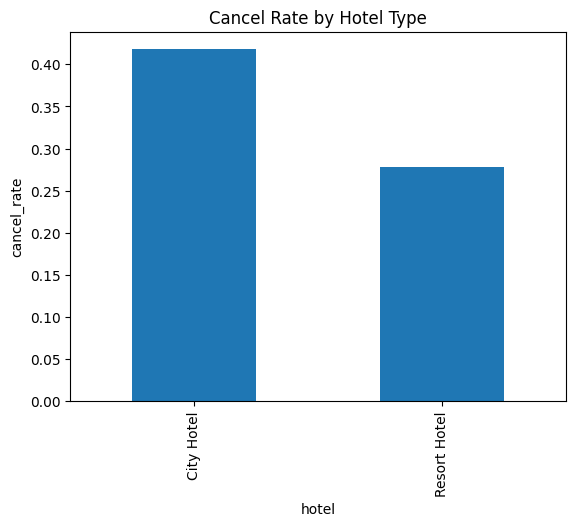

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

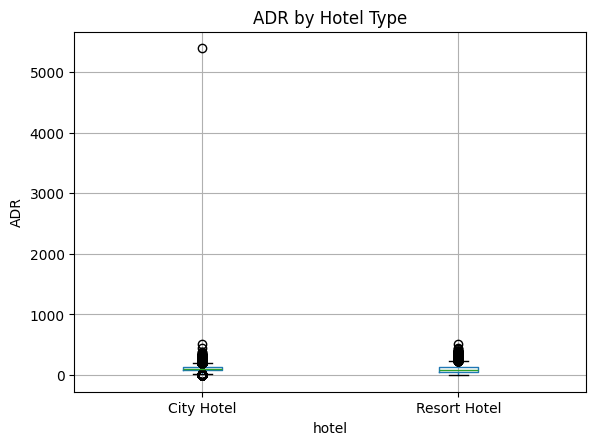

<Figure size 640x480 with 0 Axes>

In [21]:
# 4) 호텔 타입별 취소율·ADR 박스
plt.figure()
df.groupby("hotel")["is_canceled"].mean().plot(kind="bar")
plt.title("Cancel Rate by Hotel Type")
plt.ylabel("cancel_rate")
showfig("05_rate_by_hotel")

plt.figure()
df.boxplot(column="adr", by="hotel")
plt.title("ADR by Hotel Type")
plt.suptitle("")
plt.xlabel("hotel")
plt.ylabel("ADR")
showfig("06_adr_by_hotel_box")

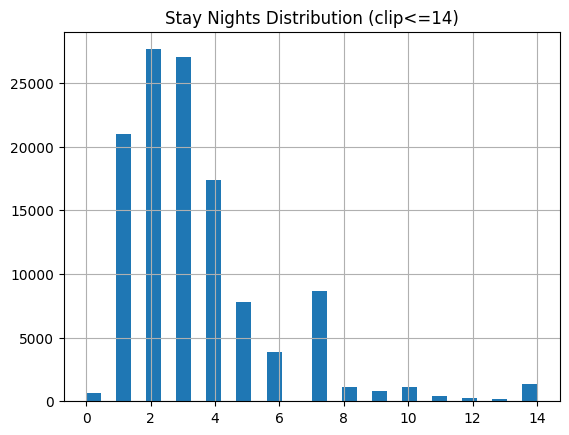

<Figure size 640x480 with 0 Axes>

/var/folders/0s/sp4g2zrn7mvbj6tfg7z3yqpw0000gn/T/ipykernel_17665/4019457960.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate2 = df.groupby(bins2)["is_canceled"].mean()


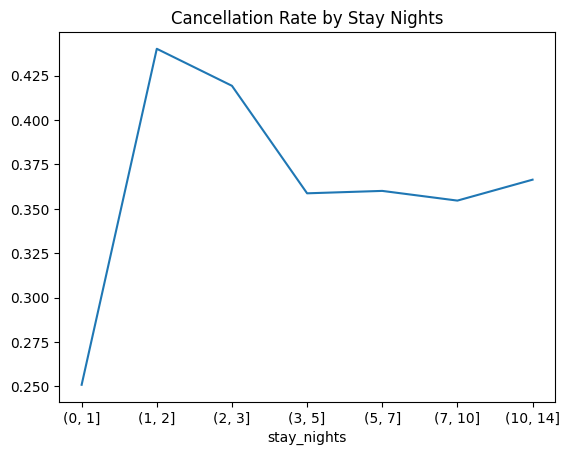

<Figure size 640x480 with 0 Axes>

In [22]:
# 5) 체류일
plt.figure()
df["stay_nights"].clip(upper=14).hist(bins=30)
plt.title("Stay Nights Distribution (clip<=14)")
showfig("07_stay_nights_hist")

bins2 = pd.cut(df["stay_nights"].clip(upper=14), bins=[0, 1, 2, 3, 5, 7, 10, 14])
rate2 = df.groupby(bins2)["is_canceled"].mean()
plt.figure()
rate2.plot()
plt.title("Cancellation Rate by Stay Nights")
showfig("08_stay_nights_rate")

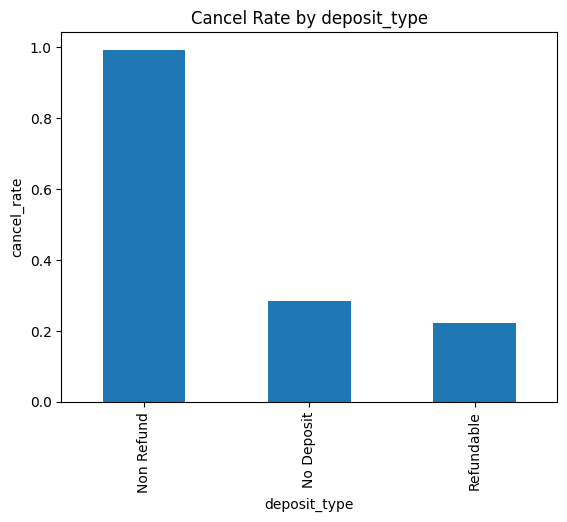

<Figure size 640x480 with 0 Axes>

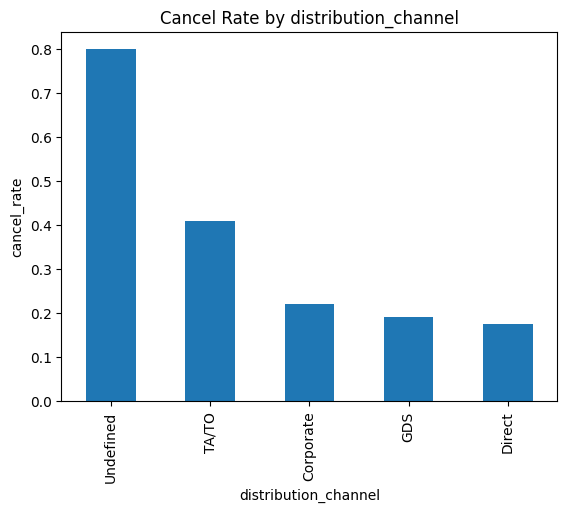

<Figure size 640x480 with 0 Axes>

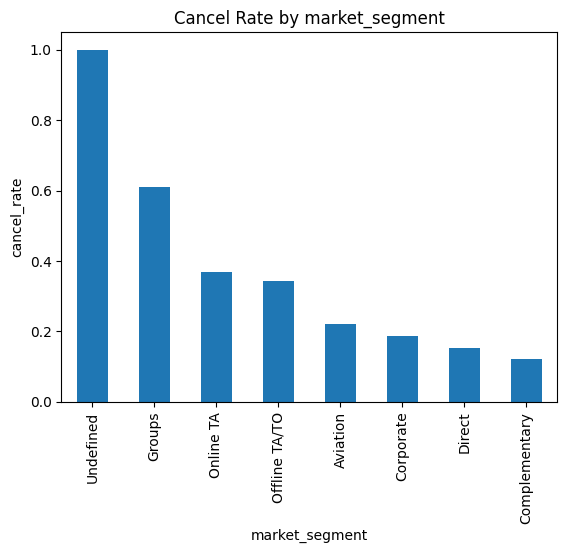

<Figure size 640x480 with 0 Axes>

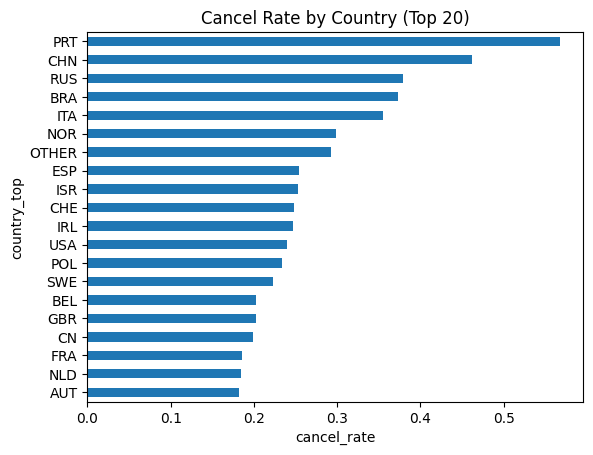

<Figure size 640x480 with 0 Axes>

In [23]:
# 6~9) 범주형 그룹별 취소율
def rate_bar(col, fname):
    plt.figure()
    df.groupby(col)["is_canceled"].mean().sort_values(ascending=False).plot(kind="bar")
    plt.ylabel("cancel_rate")
    plt.title(f"Cancel Rate by {col}")
    showfig(fname)


for col, name in [
    ("deposit_type", "09_rate_by_deposit"),
    ("distribution_channel", "10_rate_by_channel"),
    ("market_segment", "11_rate_by_segment"),
]:
    if col in df.columns:
        rate_bar(col, name)

if "country_top" in df.columns:
    plt.figure()
    df.groupby("country_top")["is_canceled"].mean().sort_values().tail(20).plot(
        kind="barh"
    )
    plt.xlabel("cancel_rate")
    plt.title("Cancel Rate by Country (Top 20)")
    showfig("12_rate_by_country_top20")

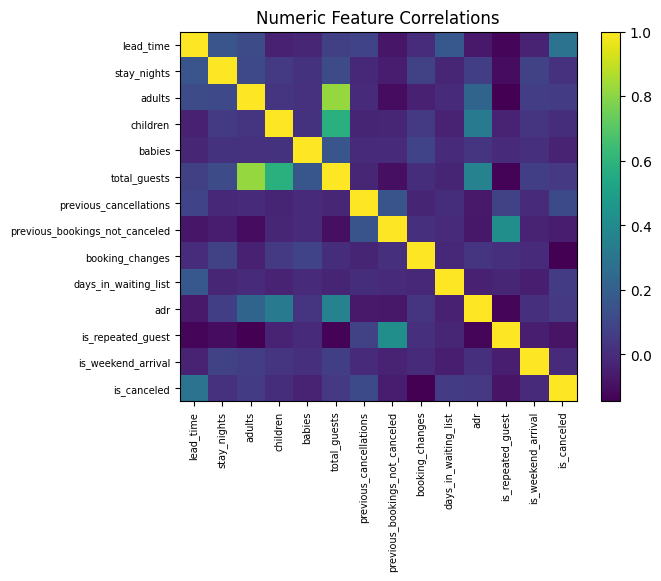

<Figure size 640x480 with 0 Axes>

In [24]:
# 10) 수치 상관행렬
num_cols = df.select_dtypes(exclude=["object", "datetime64[ns]"]).columns
corr = df[num_cols].corr(numeric_only=True)
plt.figure()
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Numeric Feature Correlations")
plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=7)
plt.yticks(range(len(num_cols)), num_cols, fontsize=7)
showfig("13_corr_heatmap")

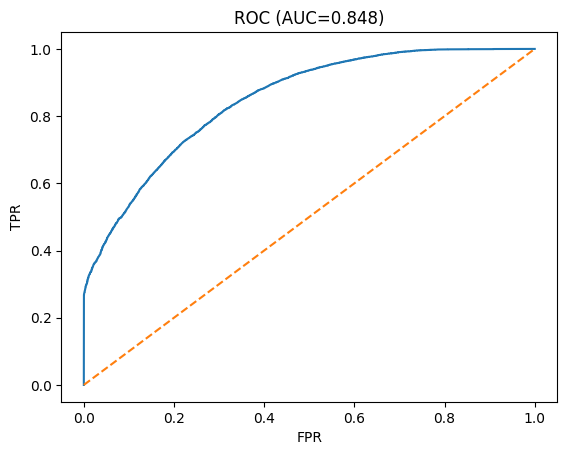

<Figure size 640x480 with 0 Axes>

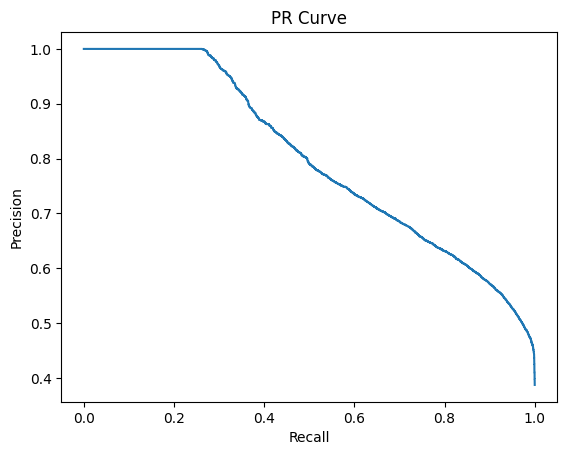

<Figure size 640x480 with 0 Axes>

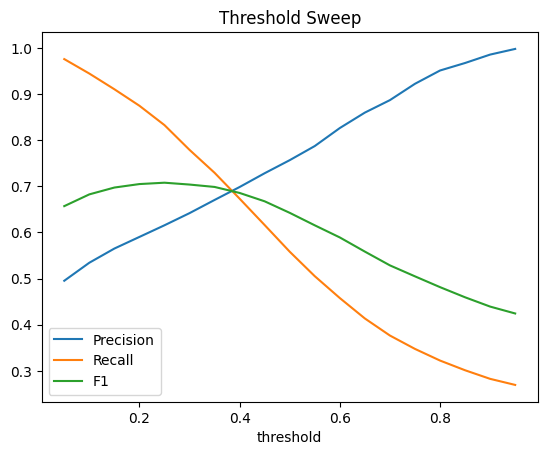

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

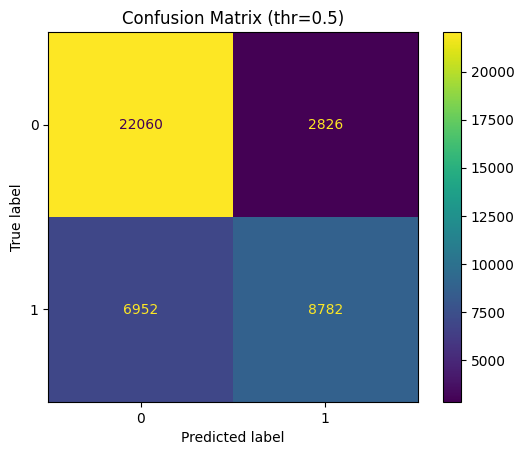

<Figure size 640x480 with 0 Axes>

In [25]:
# ===== 모델 진단 (이미 학습한 예측값 proba.npy가 있다고 가정) =====
proba_path = Path(os.path.join(ROOT_DIR,"artifacts/valid_proba.npy"))
pred_path = Path(os.path.join(ROOT_DIR,"artifacts/valid_pred.npy"))
y_path = Path(os.path.join(ROOT_DIR,"artifacts/valid_true.npy"))

if proba_path.exists():
    proba = np.load(proba_path)
    y_true = np.load(y_path)
    # 11) ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC (AUC={auc(fpr,tpr):.3f})")
    showfig("21_roc")

    # 12) PR
    prec, rec, thr = precision_recall_curve(y_true, proba)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curve")
    showfig("22_pr")

    # 13) 임계값 스윕
    ths = np.linspace(0.05, 0.95, 19)
    P, R, F = [], [], []
    for t in ths:
        p = (proba >= t).astype(int)
        TP = ((p == 1) & (y_true == 1)).sum()
        FP = ((p == 1) & (y_true == 0)).sum()
        FN = ((p == 0) & (y_true == 1)).sum()
        precision = TP / max(TP + FP, 1)
        recall = TP / max(TP + FN, 1)
        f1 = (
            0
            if precision + recall == 0
            else 2 * precision * recall / (precision + recall)
        )
        P.append(precision)
        R.append(recall)
        F.append(f1)
    plt.figure()
    plt.plot(ths, P, label="Precision")
    plt.plot(ths, R, label="Recall")
    plt.plot(ths, F, label="F1")
    plt.xlabel("threshold")
    plt.legend()
    plt.title("Threshold Sweep")
    showfig("23_threshold_sweep")

    # 14) 혼동행렬(기본 0.5)
    pred = (proba >= 0.5).astype(int)
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_true, pred)
    plt.title("Confusion Matrix (thr=0.5)")
    showfig("24_confusion_matrix")

In [26]:
def get_ct_feature_names(ct) -> list:
    """
    ColumnTransformer에서 최종 특성 이름을 추출.
    - OneHotEncoder.get_feature_names_out 사용
    - 'passthrough'는 원 컬럼명 그대로
    """
    output = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if trans == "drop":
            continue
        if trans == "passthrough":
            # cols가 컬럼명 리스트로 들어있음
            output.extend(list(cols))
        else:
            if hasattr(trans, "get_feature_names_out"):
                try:
                    feats = trans.get_feature_names_out(cols)
                except TypeError:
                    feats = trans.get_feature_names_out()
                output.extend([str(f) for f in feats])
            else:
                # fallback
                output.extend([f"{name}__{c}" for c in cols])
    return output

<Figure size 800x600 with 0 Axes>

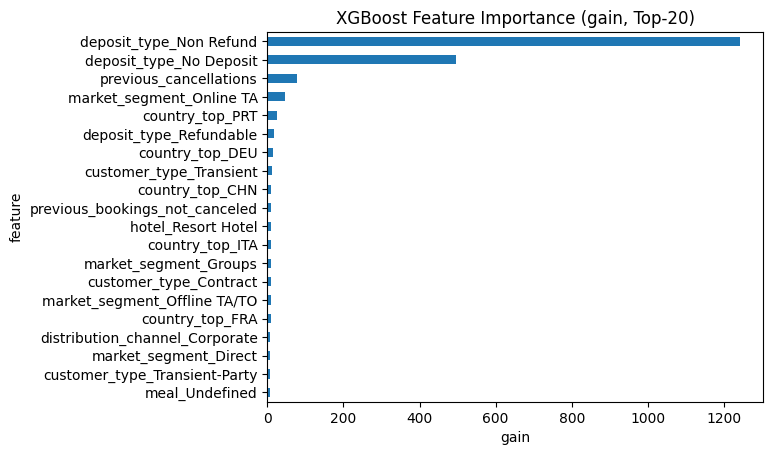

<Figure size 640x480 with 0 Axes>

[Saved] figures/25_xgb_gain_top20.png


In [27]:
pipe = joblib.load(ART_PATH / "xgb_cancel_pipeline.joblib")
pre  = pipe.named_steps.get("pre")
clf  = pipe.named_steps.get("clf")  # XGBClassifier
# ====== 중요도 (gain 기준) ======
try:
    feat_names = get_ct_feature_names(pre)
    booster = clf.get_booster()
    raw_imp = booster.get_score(importance_type="gain")  # dict: {'f0': val, ...}
    # fN -> 인덱스 숫자 추출
    items = []
    for k, v in raw_imp.items():
        if k.startswith("f"):
            idx = int(k[1:])
            name = feat_names[idx] if idx < len(feat_names) else k
        else:
            name = k
        items.append((name, v))
    imp_df = pd.DataFrame(items, columns=["feature","gain"]).sort_values("gain", ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    imp_df[::-1].plot(kind="barh", x="feature", y="gain", legend=False)
    plt.title("XGBoost Feature Importance (gain, Top-20)")
    plt.xlabel("gain")

    name = "25_xgb_gain_top20"
    showfig(name)
    print(f"[Saved] figures/{name}.png")
except Exception as e:
    print(f"[Skip] XGBoost importance due to: {e}")

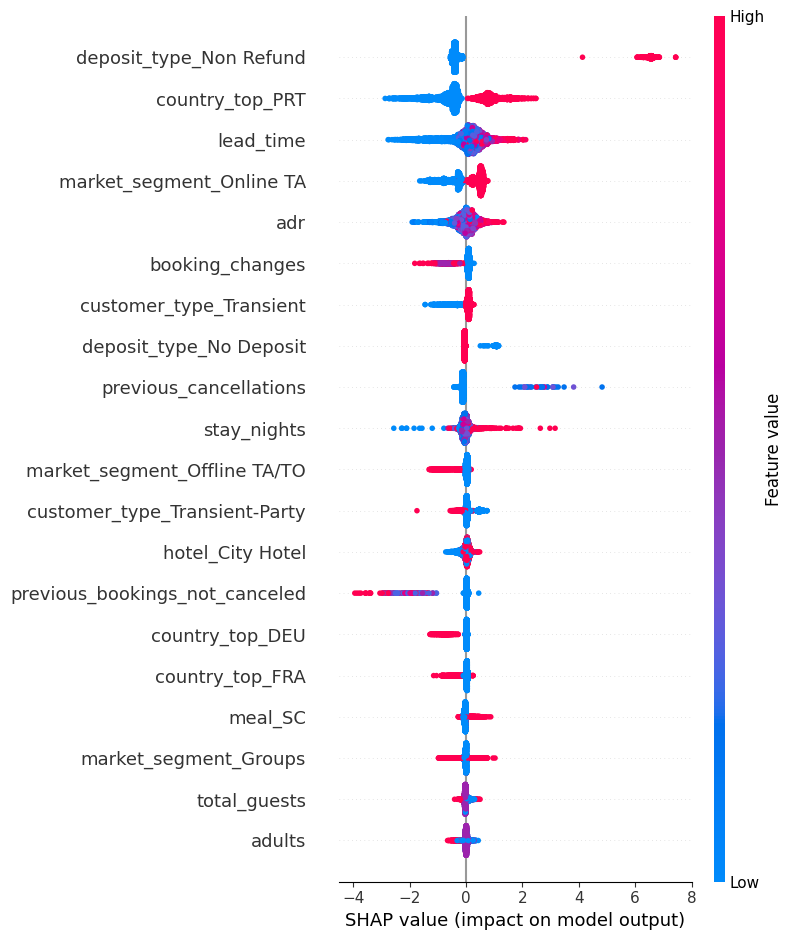

<Figure size 640x480 with 0 Axes>

[Saved] figures/31_shap_summary.png


<Figure size 640x480 with 0 Axes>

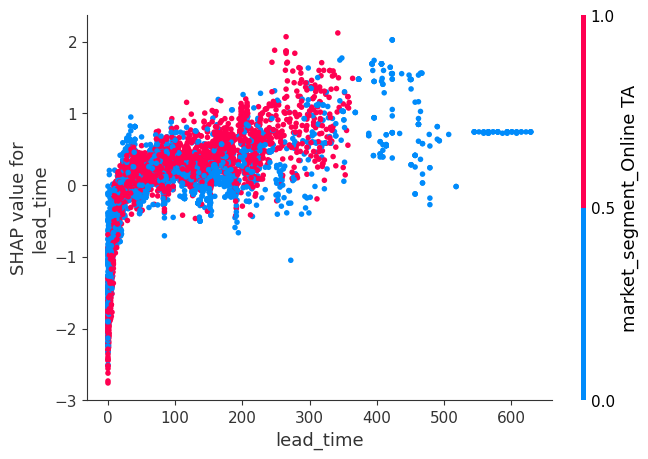

<Figure size 640x480 with 0 Axes>

[Saved] figures/32_shap_dependence_lead_time.png


<Figure size 640x480 with 0 Axes>

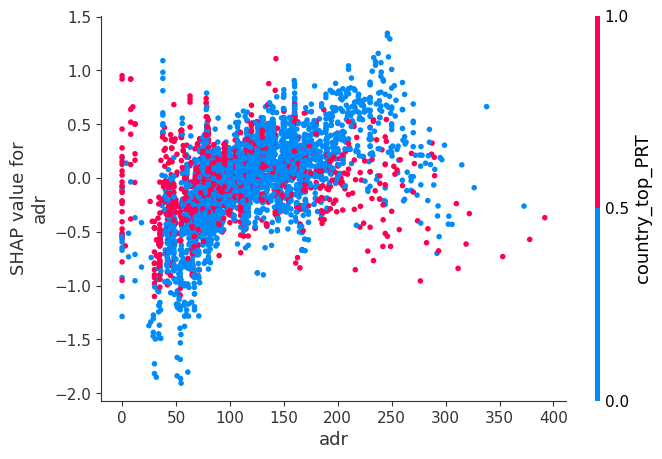

<Figure size 640x480 with 0 Axes>

[Saved] figures/33_shap_dependence_adr.png


In [28]:
try:
    # 검증 세트를 재구성(시간 기준 split 동일하게)
    data_all = pd.read_parquet(PROCESSED_DATA_PATH)
    valid_df = data_all[data_all["arrival_date"] >= "2017-01-01"].copy()
    y_val2   = valid_df.pop("is_canceled").values
    if "arrival_date" in valid_df.columns:
        valid_df.drop(columns=["arrival_date"], inplace=True)

    X_val_trans = pre.transform(valid_df)
    # 샘플링(메모리 절약)
    n = X_val_trans.shape[0]
    r = np.random.RandomState(42)
    take = min(5000, n)
    idx = np.arange(n) if n <= take else r.choice(n, size=take, replace=False)
    X_plot_sparse = X_val_trans[idx]
    X_plot = X_plot_sparse.toarray() if sp.issparse(X_plot_sparse) else np.asarray(X_plot_sparse)

    # explainer & shap values
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_plot)

    # Summary plot (Top-20)
    plt.figure()
    shap.summary_plot(shap_values, X_plot, feature_names=feat_names, max_display=20, show=False)

    name = "31_shap_summary"
    showfig(name)
    print(f"[Saved] figures/{name}.png")

    # Dependence: lead_time / adr (가능하면)
    def save_dependence(target_name: str, outname: str):
        if target_name in feat_names:
            plt.figure()
            shap.dependence_plot(
                feat_names.index(target_name),
                shap_values, X_plot, feature_names=feat_names, show=False
            )
            showfig(outname)
            print(f"[Saved] figures/{outname}.png")
        else:
            print(f"[Skip] SHAP dependence: '{target_name}' not in features")

    save_dependence("lead_time", "32_shap_dependence_lead_time")
    save_dependence("adr", "33_shap_dependence_adr")
except Exception as e:
    print(f"[Skip] SHAP plots due to: {e}")